In [62]:
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import lax, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, SVI, NUTS, MCMC, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

In [63]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [64]:
df = pd.read_csv('../data/WaffleDivorce.csv', sep=';')

standardize = lambda x: (x - x.mean()) / x.std()
df['age_scaled'] = df.MedianAgeMarriage.pipe(standardize)
df['marriage_scaled'] = df.Marriage.pipe(standardize)
df['divorce_scaled'] = df.Divorce.pipe(standardize)
df['waffle_scaled'] = df.WaffleHouses.pipe(standardize)

df.rename(columns=dict(
    MedianAgeMarriage='age',
    WaffleHouses='waffle',
), inplace=True)
df.columns = [c.lower() for c in df.columns]
print(df.shape)
df.sample(3)

(50, 17)


,location,loc,population,age,marriage,marriage se,divorce,divorce se,waffle,south,slaves1860,population1860,propslaves1860,age_scaled,marriage_scaled,divorce_scaled,waffle_scaled
11,Hawaii,HI,1.36,26.9,24.9,2.54,8.3,1.27,0,0,0,0,0.00,0.680266,1.260168,-0.762296,-0.491567
33,North Dakota,ND,0.67,25.3,26.7,2.93,8.0,1.44,0,0,0,0,0.00,-0.606290,1.734114,-0.927058,-0.491567
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205,1.454029


In [65]:
df.describe()

,population,age,marriage,marriage se,divorce,divorce se,waffle,south,slaves1860,population1860,propslaves1860,age_scaled,marriage_scaled,divorce_scaled,waffle_scaled
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,6.119600,26.05400,20.114000,1.399400,9.688000,0.961800,32.340000,0.280000,79378.340000,6.287293e+05,0.094051,3.885781e-15,-1.127987e-15,-2.742251e-16,-6.439294e-17
std,6.876156,1.24363,3.797905,0.796975,1.820814,0.525367,65.789587,0.453557,149730.921149,7.813127e+05,0.174449,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.560000,23.20000,13.500000,0.390000,6.100000,0.240000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-2.294894e+00,-1.741486e+00,-1.970547e+00,-4.915672e-01
25%,1.635000,25.32500,17.125000,0.810000,8.300000,0.572500,0.000000,0.000000,0.000000,4.332100e+04,0.000000,-5.861871e-01,-7.870127e-01,-7.622965e-01,-4.915672e-01
50%,4.435000,25.90000,19.700000,1.185000,9.750000,0.795000,1.000000,0.000000,0.000000,4.077220e+05,0.000000,-1.238310e-01,-1.090075e-01,3.405071e-02,-4.763672e-01
75%,6.677500,26.75000,22.100000,1.767500,10.900000,1.257500,39.750000,1.000000,80828.000000,9.209770e+05,0.085000,5.596519e-01,5.229198e-01,6.656364e-01,1.126318e-01
max,37.250000,29.70000,30.700000,3.920000,13.500000,2.500000,381.000000,1.000000,490865.000000,3.880735e+06,0.570000,2.931739e+00,2.787326e+00,2.093569e+00,5.299623e+00


In [ ]:
def from_df(df):
    return dict(zip(df.columns, df.T.values))

import inspect
def run_mcmc(model, data, num_warmup=1000, num_samples=2000):
    assert not set(data.keys()).difference(
        inspect.getfullargspec(model)[0]
    ), f"not all cols {list(data.keys())} in model args"
    
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup, num_samples)
    mcmc.run(rng_key_, **data, extra_fields=["num_steps", "energy"])
    return mcmc

In [ ]:
def model(divorce_scaled=None, age_scaled=None, marriage_scaled=None, waffle_scaled=None, south=None):
    a = numpyro.sample("a", dist.Normal())
    A,M,W,S = 0,0,0,0
    if age_scaled is not None:
        bA = numpyro.sample("bA", dist.Normal())
        A = bA * age_scaled
    if marriage_scaled is not None:
        bM = numpyro.sample("bM", dist.Normal())
        M = bM * marriage_scaled
    if waffle_scaled is not None:
        bW = numpyro.sample("bW", dist.Normal())
        W = bW * waffle_scaled
    if south is not None:
        bS = numpyro.sample("bS", dist.Normal())
        S = bS * south

    mu = a + A + M + W + S
    sigma = numpyro.sample('sigma', dist.Exponential(.1))

    numpyro.sample("divorce_scaled", dist.Normal(mu, sigma), obs=divorce_scaled)

mcmc = run_mcmc(model, from_df(df[['age_scaled', 'waffle_scaled', 'marriage_scaled', 'south', 'divorce_scaled']]))
mcmc.print_summary()
post_samples = mcmc.get_samples()
post_pred = Predictive(model, post_samples).get_samples(
    random.PRNGKey(1), **from_df(df[['age_scaled', 'waffle_scaled', 'marriage_scaled', 'south']])
)
prior_pred = Predictive(model, num_samples=500).get_samples(
    random.PRNGKey(2), **from_df(df[['age_scaled', 'waffle_scaled', 'marriage_scaled', 'south']])
)

In [ ]:
az.plot_ppc(
    az.from_numpyro(
        mcmc,
        prior=prior_pred,
        posterior_predictive=post_pred,
        # coords={"school": np.arange(eight_school_data["J"])},
        # dims={"theta": ["school"]},
    )
)

In [ ]:
az.plot_ppc(az.from_numpyro(mcmc, prior=prior_pred), group="prior", kind="kde")

In [ ]:
az.plot_forest(post_samples, hdi_prob=0.89)

### 6h2

('A', 'W', {'S'})
('S', 'D', {'A', 'M', 'W'})
('M', 'W', {'S'})


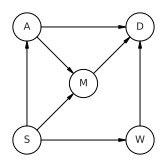

In [66]:
wd_dag = CausalGraphicalModel(
    nodes=["S", "A", "M", "D", "W"],
    edges=[
        ("S", "W"), ("W", "D"), ("S", "A"), ("A", "M"), ("S", "M"), ("M", "D"), ("A", "D")
    ]
)
pgm = daft.PGM()
coordinates = {"S": (0, 0), "W": (2, 0), "A": (0, 2), "M": (1, 1), "D": (2,2)}
for node in wd_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in wd_dag.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()

all_independencies = wd_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

In [70]:
def model(waffle_scaled=None, age_scaled=None, south=None):
    a = numpyro.sample("a", dist.Normal())
    A,S = 0,0
    if age_scaled is not None:
        bA = numpyro.sample("bA", dist.Normal())
        A = bA * age_scaled
    if south is not None:
        bS = numpyro.sample("bS", dist.Normal())
        S = bS * south

    mu = a + A + S
    sigma = numpyro.sample('sigma', dist.Exponential(1))

    numpyro.sample("marriage_scaled", dist.Normal(mu, sigma), obs=waffle_scaled)

mcmc = run_mcmc(model, from_df(df[['waffle_scaled','age_scaled', 'south']]))
mcmc.print_summary()
post_samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 369.39it/s, 3 steps of size 6.51e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.41      0.13     -0.40     -0.62     -0.20   1542.82      1.00
        bA      0.04      0.11      0.04     -0.16      0.21   1652.67      1.00
        bS      1.45      0.25      1.45      1.07      1.86   1230.55      1.00
     sigma      0.76      0.08      0.75      0.62      0.88   1084.49      1.00

Number of divergences: 0


In [72]:
def model(waffle_scaled=None, marriage_scaled=None, south=None):
    a = numpyro.sample("a", dist.Normal())
    M,S = 0,0
    if marriage_scaled is not None:
        bM = numpyro.sample("bM", dist.Normal())
        M = bM * marriage_scaled
    if south is not None:
        bS = numpyro.sample("bS", dist.Normal())
        S = bS * south

    mu = a + M + S
    sigma = numpyro.sample('sigma', dist.Exponential(1))

    numpyro.sample("marriage_scaled", dist.Normal(mu, sigma), obs=waffle_scaled)

mcmc = run_mcmc(model, from_df(df[['waffle_scaled','marriage_scaled', 'south']]))
mcmc.print_summary()
post_samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 461.44it/s, 3 steps of size 7.14e-01. acc. prob=0.88]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.39      0.12     -0.39     -0.59     -0.18   1598.80      1.00
        bM     -0.03      0.11     -0.03     -0.20      0.15   1441.93      1.00
        bS      1.42      0.24      1.43      0.99      1.77   1554.27      1.00
     sigma      0.76      0.08      0.75      0.61      0.87   1705.39      1.00

Number of divergences: 0


('A', 'W', {'S'})
('M', 'W', {'S'})


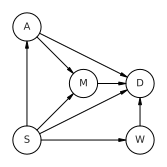

In [74]:
wd_dag = CausalGraphicalModel(
    nodes=["S", "A", "M", "D", "W"],
    edges=[
        ("S", "W"), ("W", "D"), ("S", "A"), ("A", "M"), ("S", "M"), ("M", "D"), ("A", "D"),
        ("S", "D")
    ]
)
pgm = daft.PGM()
coordinates = {"S": (0, 0), "W": (2, 0), "A": (0, 2), "M": (1, 1), "D": (2,1)}
for node in wd_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in wd_dag.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()

all_independencies = wd_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

In [75]:
def model(divorce_scaled=None, age_scaled=None, marriage_scaled=None, south=None):
    a = numpyro.sample("a", dist.Normal())
    A,M,W,S = 0,0,0,0
    if age_scaled is not None:
        bA = numpyro.sample("bA", dist.Normal())
        A = bA * age_scaled
    if marriage_scaled is not None:
        bM = numpyro.sample("bM", dist.Normal())
        M = bM * marriage_scaled
    if south is not None:
        bS = numpyro.sample("bS", dist.Normal())
        S = bS * south

    mu = a + A + M + W + S
    sigma = numpyro.sample('sigma', dist.Exponential(.1))

    numpyro.sample("divorce_scaled", dist.Normal(mu, sigma), obs=divorce_scaled)

mcmc = run_mcmc(model, from_df(df[['divorce_scaled', 'age_scaled', 'marriage_scaled', 'south']]))
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 412.35it/s, 7 steps of size 5.64e-01. acc. prob=0.88]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.12      0.13     -0.12     -0.33      0.11   1704.37      1.00
        bA     -0.58      0.17     -0.58     -0.87     -0.32   1404.95      1.00
        bM     -0.06      0.17     -0.06     -0.33      0.21   1247.65      1.00
        bS      0.43      0.26      0.43     -0.03      0.82   1714.35      1.00
     sigma      0.82      0.09      0.81      0.67      0.95   1734.84      1.00

Number of divergences: 0
